In [1]:

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2

import tensorflow as tf
import keras
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

from tqdm import tqdm
import time
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import time

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATASET_PATH= "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"

The CSV read below are as follows:
1. **df_embed**: 2048 dimension embedding per images using Resnet50
1. **df_embed_kpca**: 100 dimension embedding per image using KernelPCA on df_embed
1. **df_embed_isomap100**: 100 dimension embedding per image using ISOMAP on df_embed
1. **df_all_cluster**: Original style.csv along with the images labelled with Spectral clustering results(had trained spectral clustering on AWS)
1. **df_footwear_sample**: Sample of 100 footwear images
1. **df_apparel_sample**:  Sample of 100 apparel images
1. **df_accessories_sample**: Sample of 100 accessories images

In [4]:
#df = pd.read_csv('../input/latestembedding/df_new.csv')
#df_spec = pd.read_csv('../input/latestembedding/spec.csv')

#Embedding matrix of 4098
df_embed = pd.read_csv('../input/latestembedding/df_embs.csv')
#Main df with all cluster labels(Spectral + Kmeans)
df_all_cluster = pd.read_csv('../input/latestembedding/df_all_cluster.csv')


#Sample dataset to evaluate model performance
df_footwear_sample = pd.read_csv('../input/latestembedding/df_footwear_sample.csv')
df_apparel_sample = pd.read_csv('../input/latestembedding/df_apparel_sample.csv')
df_accessories_sample = pd.read_csv('../input/latestembedding/df_accessories_sample.csv')

#100 dimension embedding for kernal PCA result(Ran on K-PCA)
df_embed_kpca = pd.read_csv('../input/latestembedding/df_embed_kpca.csv')

#100 dimension embedding for isomap result(Ran on K-PCA)
df_embed_iso100 = pd.read_csv('../input/latestembedding/isomap_100.csv')

#2 dimension embedding for isomap result(Ran on K-PCA)
df_embed_iso2 = pd.read_csv('../input/latestembedding/isomap_2.csv')


In [5]:
del df_embed_iso100['Unnamed: 0']
del df_embed_iso2['Unnamed: 0']
del df_embed_kpca['Unnamed: 0']
del df_embed['Unnamed: 0']
#del df['Unnamed: 0']

del df_all_cluster['Unnamed: 0']

In [6]:
df_all_cluster.head()

,Unnamed: 0.1,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,spectral_cluster,cluster_class
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,0,2
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,0,5
2,2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,0,5
3,3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,0,2
4,4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg,0,2


In [7]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

**Lets visualize some images**

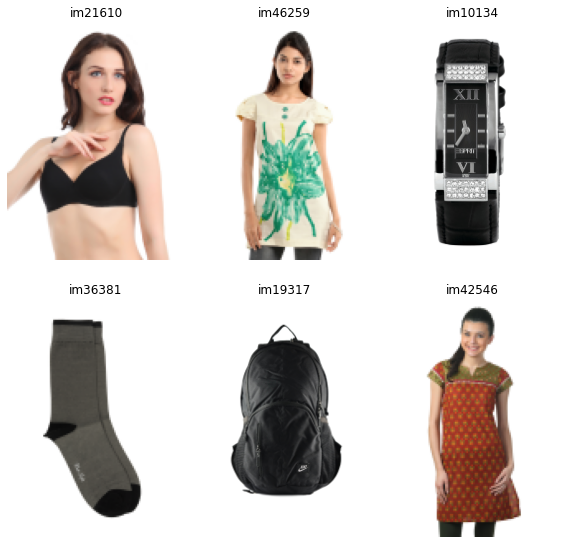

In [8]:

# generation of a dictionary of (title, images)
figures = {'im'+str(row['id']): load_image(row.image) for i, row in df_all_cluster.sample(6).iterrows()}

# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [9]:
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
        x   = image.img_to_array(img)
        x   = np.expand_dims(x, axis=0)
        x   = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        return [-1]*2048
    

# **Let's run a sample recommendation**

100%|██████████| 41755/41755 [00:03<00:00, 12857.94it/s]


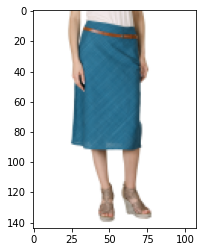

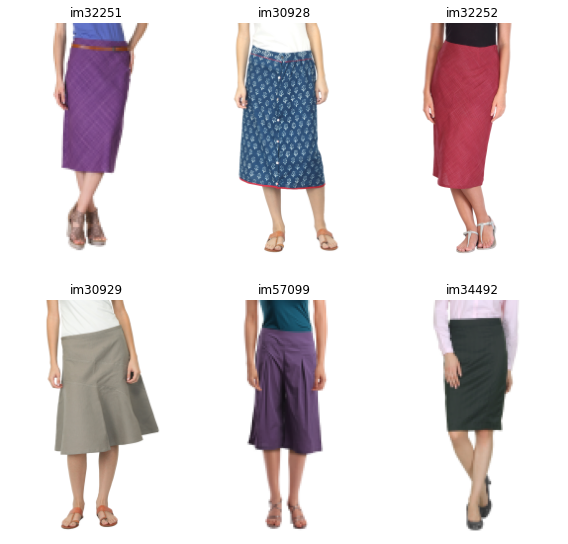

In [10]:
tqdm.pandas()

ref_image_id = 32250

def recommend(df,df_embed,top = 6,image_id=9204):
    #print(image_id)
    #First we get the index of the element in the main datagrame and then retrieve it's embeddings
    
    index = df.index[df['id'] == image_id].tolist()[0]
    
    #print(index)
    image_embedding = df_embed.iloc[index]
    t1 = time.time()
    def cosin_sim(image_embed,x):
        return 1 - distance.cosine(image_embedding,x)
    
    #Find cosine similarity with all other images
    best_all = df_embed.progress_apply(lambda x: cosin_sim(image_embedding, x),axis=1)
    t2=time.time()
    #print(str(t2-t1))
    best_all = best_all.sort_values(ascending=False)
    
    #Get top 5, we ignore index 0 and it is the cosine similarity with itself
    top_n = best_all[1:top+1]
    
    #Get the index of top 5 
    best_image_id = top_n.index.to_list()
    
    def get_image_id(ix):
        #print(ix)
        return df['id'].loc[[ix]].values[0]
    
    #Now we get the image ids of top 5 images
    best_index = list(map(get_image_id,best_image_id))

    
    return best_index

best_index = recommend(df_all_cluster,df_embed,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)


# **LET'S MAKE AN ELBOW PLOT FOR K-MEANS CLUSTER**

In [11]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(4,22) 

In [12]:
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_embed_kpca)      
      
    distortions.append(sum(np.min(cdist(df_embed_kpca, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_embed_kpca.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_embed_kpca, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_embed_kpca.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

100%|██████████| 18/18 [01:14<00:00,  4.11s/it]


Text(0.5, 1.0, 'The Elbow Method using Distortion')

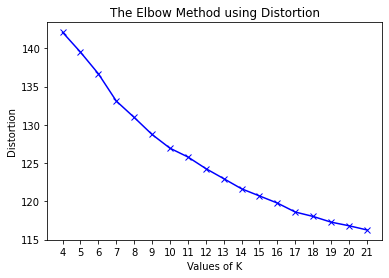

In [13]:
K = [int(i) for i in K ]
fig, ax  = plt.subplots()
ax.plot(K, distortions, 'bx-') 
ax.set_xlabel('Values of K') 
ax.set_ylabel('Distortion') 
ax.set_xticks(K)
ax.set_title('The Elbow Method using Distortion') 


In [14]:
fig.savefig('data.png')  

# **NOW LET'S FIND OUT THE OPTIMAL VALUE OF K and FIT OUR KMEANS**

In [15]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=k)
Kmean.fit(df_embed_kpca)

Kmean = KMeans(n_clusters=k,init=Kmean.cluster_centers_)
Kmean.fit(df_embed_kpca)
df_all_cluster['cluster_class'] = Kmean.labels_

**NOW LETS MAKE A PREDICTION ON KMEANS**

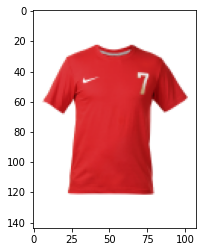

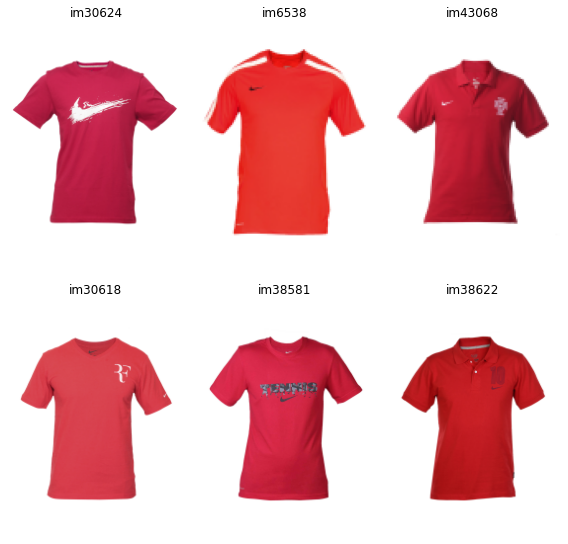

In [16]:
tqdm.pandas()

ref_image_id = 44222

def recommend_cluster(model, df,df_embed,top = 6,image_id=9204):
    #print(image_id)
    #First we get the index of the element in the main datagrame and then retrieve it's embeddings
    
    index = df.index[df['id'] == image_id].tolist()[0]
    
    #print(index)
    image_embedding = df_embed.iloc[index]
    label = Kmean.predict([image_embedding])[0]

    same_cluster_index = df['id'][df['cluster_class']==label].index.tolist()
    #same_cluster_index = df['id'][df['spectral_cluster_class']==label].index.tolist()
    
    df_cluster_embed = df_embed.iloc[same_cluster_index]
    
    
    def cosin_sim(image_embed,x):
        return 1 - distance.cosine(image_embedding,x)
    
    #Find cosine similarity with all other images
    best_all = df_cluster_embed.apply(lambda x: cosin_sim(image_embedding, x),axis=1)
    best_all = best_all.sort_values(ascending=False)
    
    #Get top 5, we ignore index 0 and it is the cosine similarity with itself
    top_n = best_all[1:top+1].index.tolist()
    def get_image_id(ix):
        #print(ix)
        return df['id'].loc[[ix]].values[0]
    
    #Now we get the image ids of top 5 images
    best_index = list(map(get_image_id,top_n))
    return best_index

best_image_id = recommend_cluster(Kmean,df_all_cluster,df_embed_kpca,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_image_id}
plot_figures(figures, 2, 3)


# **NOW I WILL RUN RECOMMENDATION FOR SPECTRAL CLUSTERING.**
**I have already run spectral clustering on AWS SAGEMAKER and have saved the cluster labels on the df_all_cluster file**

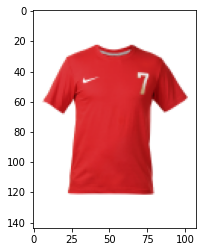

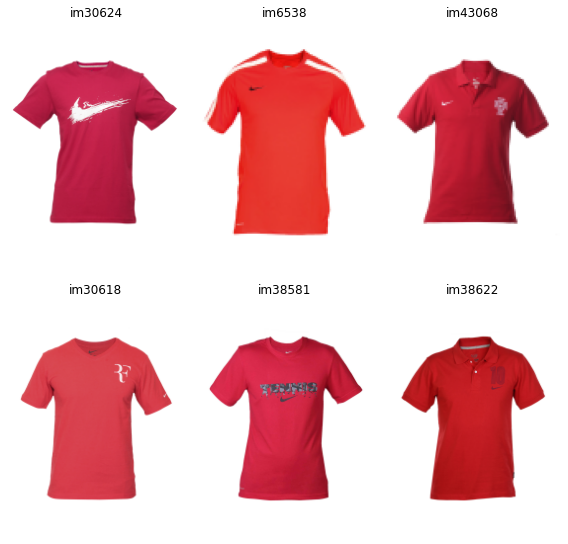

In [17]:
tqdm.pandas()

ref_image_id = 44222

def recommend_cluster_spec(df,df_embed,top = 6,image_id=9204):
    
    index = df.index[df['id'] == image_id].tolist()[0]
    
    image_embedding = df_embed.iloc[index]
    label = df['spectral_cluster'].iloc[index]

    same_cluster_index = df['id'][df['spectral_cluster']==label].index.tolist()
    
    df_cluster_embed = df_embed.iloc[same_cluster_index]
    
    
    def cosin_sim(image_embed,x):
        return 1 - distance.cosine(image_embedding,x)
    
    #Find cosine similarity with all other images
    best_all = df_cluster_embed.apply(lambda x: cosin_sim(image_embedding, x),axis=1)
    best_all = best_all.sort_values(ascending=False)
    
    #Get top 5, we ignore index 0 and it is the cosine similarity with itself
    top_n = best_all[1:top+1].index.tolist()
    def get_image_id(ix):
        #print(ix)
        return df['id'].loc[[ix]].values[0]
    
    #Now we get the image ids of top 5 images
    best_index = list(map(get_image_id,top_n))
    return best_index

best_image_id = recommend_cluster_spec(df_all_cluster,df_embed_kpca,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_image_id}
plot_figures(figures, 2, 3)


# Let's run some metrics on all the 3 different categories. I use P@6 on KernalPCA results

In [18]:
def precision_calculator(df,df_sample,df_embed,top,model):

    all_correct = []

    for index, row in df_sample.iterrows():
        ref_image_id = row['id']
        if model=='km':
            best_index = recommend_cluster(Kmean,df,df_embed,top,ref_image_id)
        else:
            best_index = recommend_cluster_spec(df,df_embed,top,ref_image_id)
        ref_gender = row['gender']
        ref_masterCategory = row['masterCategory']
        ref_subCategory = row['subCategory']
        ref_articleType = row['articleType']
        ref_baseColour = row['baseColour']
        correct = 0.0
        for item in best_index:
            
            curr_img = df[df['id']==item]

            if(curr_img['gender'].values[0] == ref_gender):
                correct+=0.2
            if(curr_img['masterCategory'].values[0] == ref_masterCategory):
                correct+=0.2
            if(curr_img['subCategory'].values[0] == ref_subCategory):
                correct+=0.2
            if(curr_img['articleType'].values[0] == ref_articleType):
                 correct+=0.2
            if(curr_img['baseColour'].values[0] == ref_baseColour):
                 correct+=0.2
        
        all_correct.append(correct/6) 

    return sum(all_correct)/len(all_correct)

#pAtk_footwear = precision_calculator(df,df_footwear_sample,df_embed_kpca,6,'sp')
#print(pAtk_footwear)
#pAtk_apparel = precision_calculator(df,df_apparel_sample,df_embed_kpca,6,'sp')
#print(pAtk_apparel)
#pAtk_accessories = precision_calculator(df_all_cluster,df_accessories_sample,df_embed_kpca,6,'sp')
#print(pAtk_accessories)

In [19]:
from sklearn.cluster import KMeans
ans = []
for i in range(4,22,2):
    print("P@6 calculated for value of k = " + str(i))
    Kmean = KMeans(n_clusters=i)
    Kmean.fit(df_embed_kpca)

    Kmean = KMeans(n_clusters=i,init=Kmean.cluster_centers_)
    Kmean.fit(df_embed_kpca)
    df_all_cluster['cluster_class'] = Kmean.labels_
    pAtk_footwear = precision_calculator(df_all_cluster,df_footwear_sample,df_embed_kpca,6,'km')  
    pAtk_apparel = precision_calculator(df_all_cluster,df_apparel_sample,df_embed_kpca,6,'km')
    pAtk_accessories = precision_calculator(df_all_cluster,df_accessories_sample,df_embed_kpca,6,'km')
    ans.append([i,pAtk_footwear,pAtk_apparel,pAtk_accessories])

P@6 calculated for value of k = 4
P@6 calculated for value of k = 6
P@6 calculated for value of k = 8
P@6 calculated for value of k = 10
P@6 calculated for value of k = 12
P@6 calculated for value of k = 14
P@6 calculated for value of k = 16
P@6 calculated for value of k = 18
P@6 calculated for value of k = 20


In [20]:
df_kmeans_result = pd.DataFrame(ans, columns = ['K Value', 'Footwear', 'Apparel','Accessories'])
 
# print dataframe.
print(df_kmeans_result)

   K Value  Footwear   Apparel  Accessories
0        4  0.772667  0.814000     0.810000
1        6  0.776000  0.815000     0.808667
2        8  0.776667  0.812333     0.802333
3       10  0.776000  0.812000     0.806667
4       12  0.776667  0.811000     0.807667
5       14  0.773333  0.809000     0.801667
6       16  0.772667  0.808000     0.800000
7       18  0.774333  0.806667     0.799333
8       20  0.769667  0.805667     0.798667


In [21]:
import seaborn as sns


# Now Let's visualize Kmeans clustering using TSNE

In [22]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed_kpca)

In [23]:
df_all_cluster['tsne-2d-one'] = tsne_results[:,0]
df_all_cluster['tsne-2d-two'] = tsne_results[:,1]

In [24]:
df_all_cluster.head()

,Unnamed: 0.1,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,spectral_cluster,cluster_class,tsne-2d-one,tsne-2d-two
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,0,1,2.128302,-4.846176
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,0,11,6.261989,-4.973133
2,2,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,0,11,5.358933,-4.818806
3,3,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,0,1,2.643075,-1.598258
4,4,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg,0,6,4.121753,0.281767


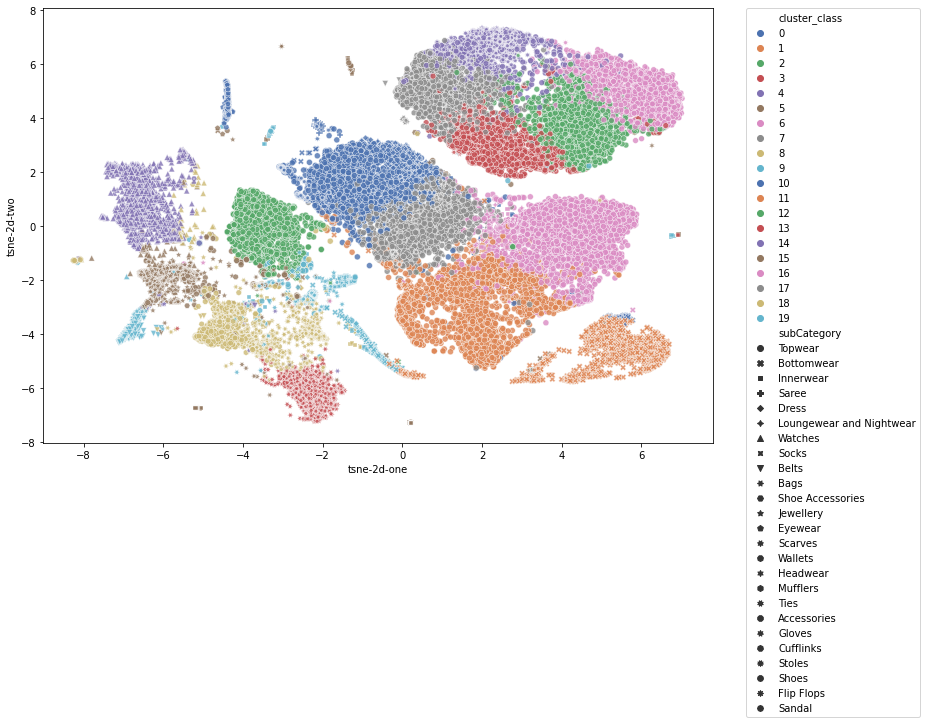

In [25]:

plt.figure(figsize=(12,8))
sns.color_palette("husl", 9)
a = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="cluster_class",
                style="subCategory",
                data=df_all_cluster,
                 palette="deep",
                legend="full",
                alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
fig = a.get_figure()
plt.savefig('subCategory.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

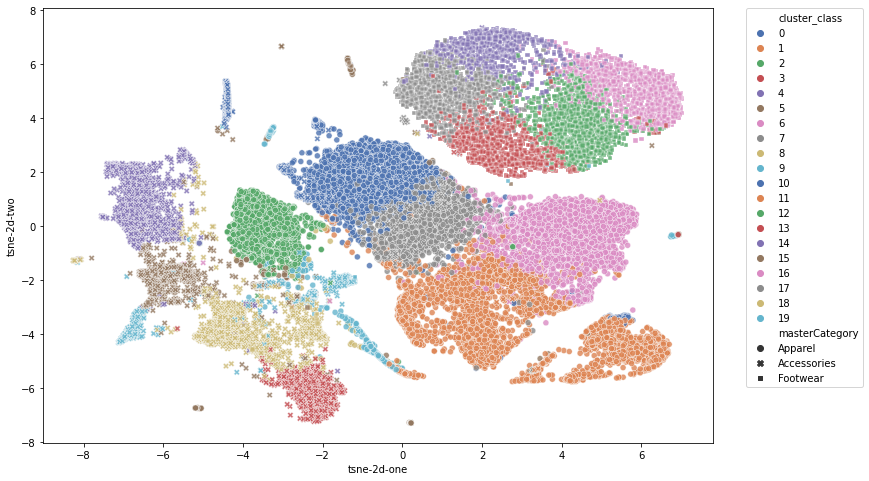

In [27]:

plt.figure(figsize=(12,8))
sns.color_palette("husl", 9)
a = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="cluster_class",
                style="masterCategory",
                data=df_all_cluster,
                 palette="deep",
                legend="full",
                alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [28]:
fig = a.get_figure()
plt.savefig('masterCategory.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

# Let's visualize using Spectral clustering

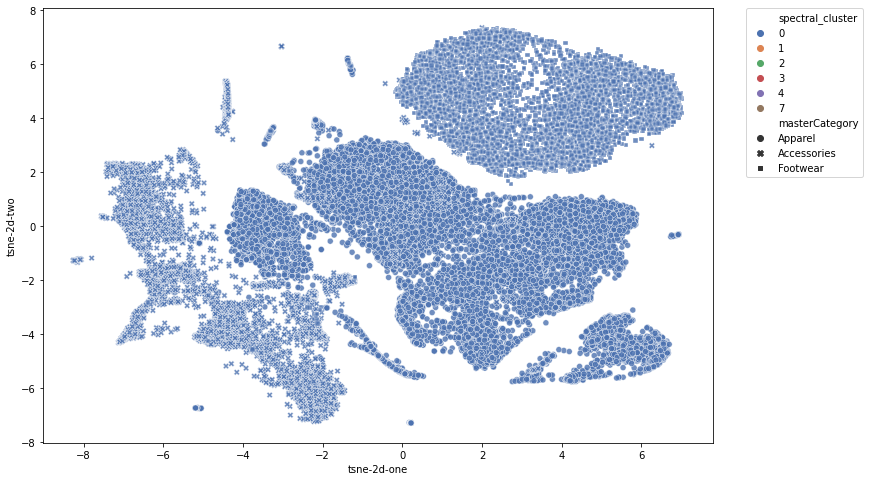

In [29]:
plt.figure(figsize=(12,8))
sns.color_palette("husl", 9)
a = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="spectral_cluster",
                style="masterCategory",
                data=df_all_cluster,
                 palette="deep",
                legend="full",
                alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [30]:
fig = a.get_figure()
plt.savefig('spectral_cluster.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>